In [42]:
'''
Method developed by Anoop Praturu: https://www.biorxiv.org/content/10.1101/2022.10.12.511940v1
Code from Anoop Praturu on Oct 2021
Move from pystan to cmdstanpy based on suggestions by Milo Julis
Edited by Mingchen Yao on May 26 2023
'''

import numpy as np
import diptest  
import matplotlib.pyplot as plt
import cmdstanpy as stan
import scipy.stats as stats
import pickle
import seaborn as sns
%matplotlib inline

import pandas as pd

import plotly.express as px
from matplotlib import rcParams
import plotly.express as px
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from scipy.stats import pearsonr


In [ ]:
# # if there is anything wrong with comstan: re-install it. Otherwise don't run this cell
# from cmdstanpy import install_cmdstan
# install_cmdstan(overwrite = True)

In [ ]:
!python --version

# Functions for Generating Synthetic Data

In [2]:
#returns hyperbolic distance between vectors in poincare ball
def poincare_dist(v1, v2):
    sq = np.sum(np.square(v1-v2))
    r1 = np.sum(np.square(v1))
    r2 = np.sum(np.square(v2))
    inv = 2.0*sq/((1.0-r1)*(1.0-r2))
    return np.arccosh(1.0 + inv)

#return NxN symmetric distance matrix from poincare coordinates
def get_dmat(p_coords):
    N = p_coords.shape[0]
    dists = np.zeros((N, N))
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            dists[i][j] = poincare_dist(p_coords[i], p_coords[j])
            dists[j][i] = dists[i][j]
    return dists

In [ ]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=5; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_dim = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_dim[j][i] = mat_dim[i][j]
mat_dim = 2.0*mat_dim/np.max(mat_dim)

# Code for fitting Bayesian Model

In [3]:
path = '/Users/iuliarusu/Documents/Sharpee/HMDS-example/model/'
ltz_m = stan.CmdStanModel(stan_file=path+'lorentz.stan')

## Run the optimizer given the synthetically generated Data set

In [4]:
ON = pd.read_csv('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/ON_cluster.csv') 
OFF = pd.read_csv('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/OFF_cluster.csv')
AVA_0_df = pd.read_csv ('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/AVA_0_df.csv')
RME_0_df = pd.read_csv ('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/RME_0_df.csv')
SMDD_0_df = pd.read_csv ('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/SMDD_0_df.csv')
SMDV_0_df = pd.read_csv ('/Users/iuliarusu/Documents/Sharpee/Clustering/clustered_bacterial_stim/SMDV_0_df.csv')

In [5]:
ON_0 = ON[ON['worm_id'] == 0]
OFF_0 = OFF[OFF['worm_id'] == 0]

# for a single worm, concatenate all clustered cells


In [6]:
# example for w0
ON_0 = np.array(ON_0.iloc[:, 1: -2])
OFF_0 = np.array(OFF_0.iloc[:, 1: -2])
AVA_0 = np.array(AVA_0_df.iloc[:, 1: -2])
RME_0 = np.array(RME_0_df.iloc[:, 1: -2])
SMDV_0 = np.array(SMDV_0_df.iloc[:, 1: -2])
SMDD_0 = np.array(SMDD_0_df.iloc[:, 1: -2])

In [7]:
#concatenate all cell types
w_0 = np.concatenate((ON_0, OFF_0, AVA_0, RME_0, SMDV_0, SMDD_0), axis=0)

In [8]:
w_0.shape

(29, 1600)

In [12]:
w_0_df = pd.DataFrame(w_0)

# Distance Matrix by Time


In [51]:
# #seperate single cell into bins, average each bin, and subtract the preceding bin from the current bin
# bin_size = 10
# all_differences = []
# for index, row in w_0_df.iterrows():
#     differences = []
#     previous_average = None
#     for i in range(0, len(row), bin_size):
#         chunk = row[i:i+bin_size]
#         current_average = chunk.mean()
#         if previous_average is not None:
#             difference = current_average - previous_average
#             differences.append(difference)
#         previous_average = current_average
#     all_differences.append(differences)
# differences_df = pd.DataFrame(all_differences)


    


In [13]:
# Number of bins to divide each neuron into
bin_number = 6
binned_neurons = []

# Binning each neuron in the DataFrame `w_0_df`
for neuron_idx, row in w_0_df.iterrows():
    # Calculate the bin size for each neuron
    bin_size = len(row) // bin_number
    neuron_bins = []
    
    for bin_idx in range(bin_number):
        # Calculate the start and end indices for each bin
        start_idx = bin_idx * bin_size
        # Ensure the last bin captures any remaining points
        end_idx = start_idx + bin_size if bin_idx < bin_number - 1 else len(row)
        bin_data = row[start_idx:end_idx]
        
        # Store as tuple (neuron index, bin index, bin data)
        neuron_bins.append((neuron_idx, bin_idx, bin_data))
        
    binned_neurons.append(neuron_bins)

# Example output to verify
for neuron in binned_neurons:
    for bin_label in neuron:
        print(f"Neuron: {bin_label[0]}, Bin: {bin_label[1]}, Data: {bin_label[2]}")

Neuron: 0, Bin: 0, Data: 0      0.111328
1      0.113690
2      0.104047
3      0.097544
4      0.128698
         ...   
261    0.047875
262    0.049974
263    0.054959
264    0.057547
265    0.049692
Name: 0, Length: 266, dtype: float64
Neuron: 0, Bin: 1, Data: 266    0.071702
267    0.056145
268    0.069394
269    0.072318
270    0.036514
         ...   
527    0.044466
528    0.025815
529    0.063705
530    0.048804
531    0.038980
Name: 0, Length: 266, dtype: float64
Neuron: 0, Bin: 2, Data: 532    0.047328
533    0.046514
534    0.055647
535    0.043924
536    0.047948
         ...   
793    0.055853
794    0.052115
795    0.042639
796    0.045641
797    0.026513
Name: 0, Length: 266, dtype: float64
Neuron: 0, Bin: 3, Data: 798     0.045404
799     0.050228
800     0.032680
801     0.049105
802     0.043796
          ...   
1059    0.031421
1060    0.041351
1061    0.049770
1062    0.035177
1063    0.063826
Name: 0, Length: 266, dtype: float64
Neuron: 0, Bin: 4, Data: 1064    0.07

In [17]:
# Define the minimum correlation distance function with a length check
def min_correlation_distance(r1, r2):
    T1 = len(r1)
    T2 = len(r2)
    
    # If r1 is shorter than r2, swap them
    if T1 < T2:
        r1, r2 = r2, r1
        T1, T2 = T2, T1
    
    all_dists = []
    for i in range(T1 - T2 + 1):
        corr_coef, _ = pearsonr(r1[i:i+T2], r2)
        d = (1 - corr_coef**2) *2
        all_dists.append(d)
    
    # Check if all_dists is empty
    return np.min(all_dists) if all_dists else np.nan  # Return NaN if no distance was calculated

# Flatten `binned_neurons` to create a list of all bins with identifiers
all_bins = [(neuron_idx, bin_idx, bin_data) for neuron in binned_neurons for neuron_idx, bin_idx, bin_data in neuron]

# Initialize a distance matrix to store pairwise distances between bins
num_bins = len(all_bins)
distance_matrix = np.zeros((num_bins, num_bins))

# Calculate pairwise distances between all bins
for i in range(num_bins):
    for j in range(i + 1, num_bins):
        # Extract the bin data for each pair of bins
        _, _, bin_data_i = all_bins[i]
        _, _, bin_data_j = all_bins[j]
        
        # Compute the minimum correlation distance
        distance = min_correlation_distance(bin_data_i, bin_data_j)
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance 

In [18]:
#scroll through distance data from all neurons

for i in range(len(all_bins)):
    for j in range(i + 1, len(all_bins)):
        neuron_i, bin_i, _ = all_bins[i]
        neuron_j, bin_j, _ = all_bins[j]
        distance = distance_matrix[i, j]
        print(f"Distance between Neuron {neuron_i} Bin {bin_i} and Neuron {neuron_j} Bin {bin_j}: {distance}")


Distance between Neuron 0 Bin 0 and Neuron 0 Bin 1: 1.879003530500523
Distance between Neuron 0 Bin 0 and Neuron 0 Bin 2: 1.7511238996020533
Distance between Neuron 0 Bin 0 and Neuron 0 Bin 3: 1.9877363247357516
Distance between Neuron 0 Bin 0 and Neuron 0 Bin 4: 1.992306912755378
Distance between Neuron 0 Bin 0 and Neuron 0 Bin 5: 1.9877736585063395
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 0: 0.4699510922848864
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 1: 1.9507615269178928
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 2: 1.8804088008634534
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 3: 1.9468584157697404
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 4: 1.9873021046679382
Distance between Neuron 0 Bin 0 and Neuron 1 Bin 5: 1.9692235871423849
Distance between Neuron 0 Bin 0 and Neuron 2 Bin 0: 0.6030619705505
Distance between Neuron 0 Bin 0 and Neuron 2 Bin 1: 1.860960208545091
Distance between Neuron 0 Bin 0 and Neuron 2 Bin 2: 1.9813799635242475
Distance bet

In [19]:
#only see bins that are consequtive time differences with each other
for i in range(len(all_bins)):
    for j in range(i + 1, len(all_bins)):
        neuron_i, bin_i, _ = all_bins[i]
        neuron_j, bin_j, _ = all_bins[j]
        
        # Check if it's the same neuron but different bins
        if neuron_i == neuron_j and bin_i != bin_j:
            distance = distance_matrix[i, j]
            print(f"Distance between Neuron {neuron_i} Bin {bin_i} and Bin {bin_j}: {distance}")


Distance between Neuron 0 Bin 0 and Bin 1: 1.879003530500523
Distance between Neuron 0 Bin 0 and Bin 2: 1.7511238996020533
Distance between Neuron 0 Bin 0 and Bin 3: 1.9877363247357516
Distance between Neuron 0 Bin 0 and Bin 4: 1.992306912755378
Distance between Neuron 0 Bin 0 and Bin 5: 1.9877736585063395
Distance between Neuron 0 Bin 1 and Bin 2: 1.9866119265828923
Distance between Neuron 0 Bin 1 and Bin 3: 1.9041015753581993
Distance between Neuron 0 Bin 1 and Bin 4: 1.9519941093685556
Distance between Neuron 0 Bin 1 and Bin 5: 1.992286553408566
Distance between Neuron 0 Bin 2 and Bin 3: 1.959030883837401
Distance between Neuron 0 Bin 2 and Bin 4: 1.977768716181618
Distance between Neuron 0 Bin 2 and Bin 5: 1.9419168614788778
Distance between Neuron 0 Bin 3 and Bin 4: 1.970517059999364
Distance between Neuron 0 Bin 3 and Bin 5: 1.8734686289353242
Distance between Neuron 0 Bin 4 and Bin 5: 1.9720631992748174
Distance between Neuron 1 Bin 0 and Bin 1: 1.9669836878460207
Distance betwe

In [20]:

distance_matrix_squaredp = distance_matrix

In [21]:
distance_matrix_squaredp.shape

(174, 174)

Distance matrix by shape ( example)

In [ ]:
#take 144 x 144 matrix example
def dist(r1, r2): #r1= neuron1 @ T0, r2= neuron2 @ T3
    T1 = len(r1); T2 = len(r2)
    assume T1 > T2
    all_dists = []
    for i in range(T1-T2):
        d = corr_dist(r1[i:i+T2], r2)
        all_dists.append(d)
data = 
    for in range(144):
        for j in range(144):
            dmat[i][j] = dist(data[i], data[j])
            dmat[j][i] = dmat[i][j]


In [22]:
#dictionary to specify input to simulation

# dat={'N':100, 'D':5, 'deltaij':mat_dim}
dat = {'N': 174 , 'D': 3 , 'deltaij':distance_matrix_squaredp}
#run optimizer
model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)

11:25:37 - cmdstanpy - INFO - Chain [1] start processing
11:46:23 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# build result 
hyp_emb = {'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda')}

# # and save
# fdname = './emb5d.pickle'
# with open(fdname,'wb') as file:
#     pickle.dump(hyp_emb, file,  protocol=pickle.HIGHEST_PROTOCOL)

13:17:00 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


In [ ]:
# # load existing results
# fdname = './emb5d.pickle'
# with open(fdname, 'rb') as file:
#     hyp_emb = pickle.load(file)

## Some utility functions for post-processing the simulation output

In [24]:
def d_lor(t1, t2, E1, E2):
    return np.arccosh(t1*t2 - np.dot(E1, E2))

#returns embedding distance matrix from optimization fit
def get_embed_dmat(fit):
    N = fit['euc'].shape[0]
    fit_ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))

    fit_mat = np.zeros((N, N))

    for i in np.arange(N):
        for j in np.arange(i+1,N):
            fit_mat[i][j] = d_lor(fit_ts[i], fit_ts[j], fit['euc'][i], fit['euc'][j])
            fit_mat[j][i] = fit_mat[i][j]
            
    return fit_mat

#return poincare coordinates
def get_poin(fit):
    ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))
    return (fit['euc'].T / (ts + 1)).T

In [25]:
def process_sim(fit):
    fit['emb_mat'] = get_embed_dmat(fit)/fit['lambda']
    fit['pcoords'] = get_poin(fit)
    fit['radii'] = 2.0*np.arctanh(np.sqrt(np.sum(np.square(fit['pcoords']), axis=1)))

In [26]:
#run this function after running the optimizer to process the output data into more usable forms
process_sim(hyp_emb)

In [27]:
#curvature (or radius)
hyp_emb['lambda']

5.79677

In [28]:
#poincare embedding coordinates
hyp_emb['pcoords']

array([[-5.06801031e-01, -6.57190504e-01, -5.47385628e-01],
       [-5.63189314e-01, -6.06909839e-01,  5.50809870e-01],
       [-6.63473299e-01,  2.96824734e-01,  6.77639366e-01],
       [ 2.26445509e-01,  7.74635859e-01, -5.80144850e-01],
       [ 9.26072730e-01,  2.18312287e-01, -2.92587921e-01],
       [ 4.76260973e-02,  9.40810041e-01,  3.23164392e-01],
       [-5.00505430e-01, -6.71383680e-01, -5.38536486e-01],
       [-5.68873802e-01, -5.92575898e-01,  5.59898566e-01],
       [-6.64211236e-01,  2.60620231e-01,  6.91711833e-01],
       [ 2.83799850e-01,  7.59437975e-01, -5.75286141e-01],
       [ 8.87992052e-01,  1.93666459e-01, -4.04673739e-01],
       [-8.35407700e-01,  5.25549311e-01,  1.32564005e-01],
       [-4.96473782e-01, -6.79141721e-01, -5.31744963e-01],
       [-5.73719636e-01, -6.01393320e-01,  5.46482877e-01],
       [-6.47955839e-01,  2.20653507e-01,  7.21559650e-01],
       [ 3.93639328e-01,  7.61952416e-01, -5.04339812e-01],
       [ 8.84969536e-01,  1.17118363e-02

In [29]:
#emebdding uncertainties
hyp_emb.keys()

dict_keys(['euc', 'sig', 'lambda', 'emb_mat', 'pcoords', 'radii'])

# Shepard Diagram

In [46]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [ ]:
# color brewer paisley hex color references
#8dd3c7
#ffffb3
#bebada
#fb8072
#80b1d3

In [30]:
column = ['ON'] * (ON_0.shape[0] * 6) + ['OFF'] * (OFF_0.shape[0] *6) + ['AVA'] * (AVA_0.shape[0] *6) + ['RME'] * (RME_0.shape[0] *6) + ['SMDV'] * (SMDV_0.shape[0] *6) + ['SMDD'] * (SMDD_0.shape[0] *6)
cell_type = np.array(column)

In [31]:
# Define each cell type and its corresponding data size
cell_types = {
    'ON': ON_0.shape[0],
    'OFF': OFF_0.shape[0],
    'AVA': AVA_0.shape[0],
    'RME': RME_0.shape[0],
    'SMDV': SMDV_0.shape[0],
    'SMDD': SMDD_0.shape[0]
}

# Create the labeled array
labeled_column = []

for cell_type, count in cell_types.items():
    for i in range(1, count + 1):  # Add suffix from 1 to the count
        labeled_column.extend([f"{cell_type}_{i}"] * 6)  # Repeat each label 6 times

# Convert to numpy array
labeled_cell_type = np.array(labeled_column)

In [32]:
# Define each cell type and its corresponding data size
cell_types = {
    'ON': ON_0.shape[0],
    'OFF': OFF_0.shape[0],
    'AVA': AVA_0.shape[0],
    'RME': RME_0.shape[0],
    'SMDV': SMDV_0.shape[0],
    'SMDD': SMDD_0.shape[0]
}

# Create the labeled array
labeled_column = []

for cell_type, count in cell_types.items():
    for i in range(1, count + 1):  # Add suffix from 1 to the count
        for j in range(6):  # Add index within each group of 6
            labeled_column.append(f"{cell_type}_{i}_{j}")

# Convert to numpy array
labeled_cell_type = np.array(labeled_column)

# Output to check
print(labeled_cell_type)

['ON_1_0' 'ON_1_1' 'ON_1_2' 'ON_1_3' 'ON_1_4' 'ON_1_5' 'ON_2_0' 'ON_2_1'
 'ON_2_2' 'ON_2_3' 'ON_2_4' 'ON_2_5' 'ON_3_0' 'ON_3_1' 'ON_3_2' 'ON_3_3'
 'ON_3_4' 'ON_3_5' 'ON_4_0' 'ON_4_1' 'ON_4_2' 'ON_4_3' 'ON_4_4' 'ON_4_5'
 'ON_5_0' 'ON_5_1' 'ON_5_2' 'ON_5_3' 'ON_5_4' 'ON_5_5' 'ON_6_0' 'ON_6_1'
 'ON_6_2' 'ON_6_3' 'ON_6_4' 'ON_6_5' 'ON_7_0' 'ON_7_1' 'ON_7_2' 'ON_7_3'
 'ON_7_4' 'ON_7_5' 'ON_8_0' 'ON_8_1' 'ON_8_2' 'ON_8_3' 'ON_8_4' 'ON_8_5'
 'OFF_1_0' 'OFF_1_1' 'OFF_1_2' 'OFF_1_3' 'OFF_1_4' 'OFF_1_5' 'OFF_2_0'
 'OFF_2_1' 'OFF_2_2' 'OFF_2_3' 'OFF_2_4' 'OFF_2_5' 'OFF_3_0' 'OFF_3_1'
 'OFF_3_2' 'OFF_3_3' 'OFF_3_4' 'OFF_3_5' 'OFF_4_0' 'OFF_4_1' 'OFF_4_2'
 'OFF_4_3' 'OFF_4_4' 'OFF_4_5' 'OFF_5_0' 'OFF_5_1' 'OFF_5_2' 'OFF_5_3'
 'OFF_5_4' 'OFF_5_5' 'OFF_6_0' 'OFF_6_1' 'OFF_6_2' 'OFF_6_3' 'OFF_6_4'
 'OFF_6_5' 'OFF_7_0' 'OFF_7_1' 'OFF_7_2' 'OFF_7_3' 'OFF_7_4' 'OFF_7_5'
 'AVA_1_0' 'AVA_1_1' 'AVA_1_2' 'AVA_1_3' 'AVA_1_4' 'AVA_1_5' 'AVA_2_0'
 'AVA_2_1' 'AVA_2_2' 'AVA_2_3' 'AVA_2_4' 'AVA_2_5' 'AVA_3_0' 'AVA

AttributeError: 'numpy.ndarray' object has no attribute 'values'

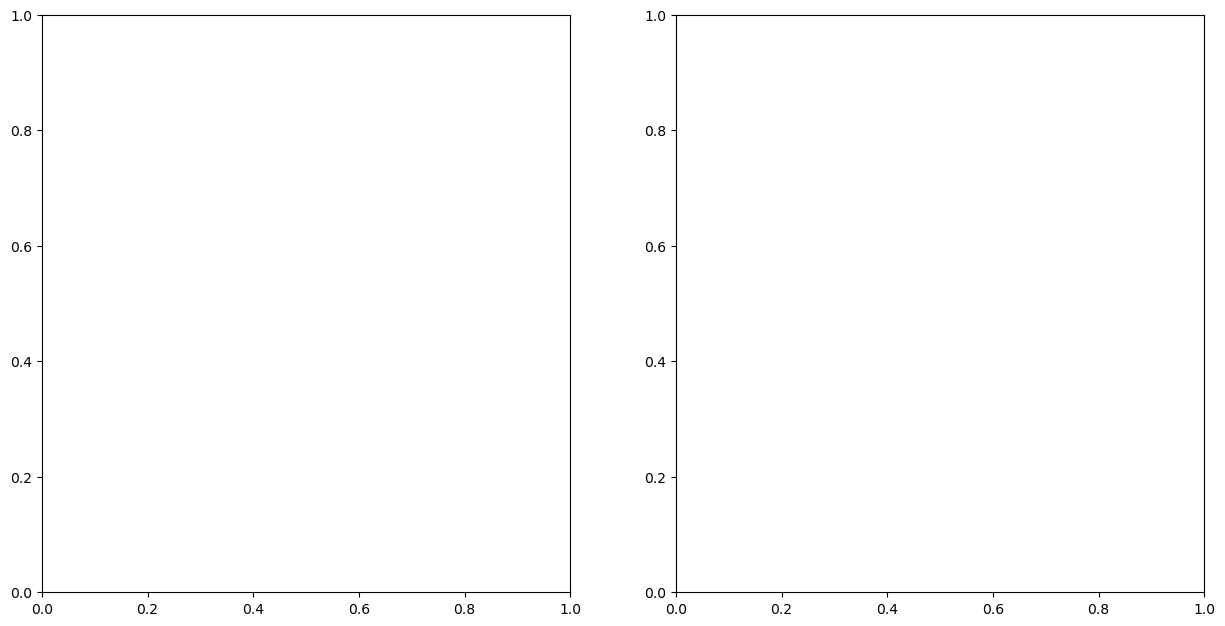

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(distance_matrix_squaredp.values[np.triu_indices(174, k=1)], hyp_emb['emb_mat'][np.triu_indices(174, k=1)], c='#8dd3c7', edgecolor='black', alpha=0.7) #cornflowerblue, lightcoral
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb['sig'], color ='#bebada', edgecolor='black') #cornflowerblue, lightcoral
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

In [33]:
hyperbolic_df= pd.DataFrame(hyp_emb['pcoords'], columns=['x', 'y', 'z'])



In [35]:
#cell type label column

hyperbolic_df['cluster labels'] = labeled_cell_type.T


In [36]:
hyperbolic_df

,x,y,z,cluster labels
0,-0.506801,-0.657191,-0.547386,ON_1_0
1,-0.563189,-0.606910,0.550810,ON_1_1
2,-0.663473,0.296825,0.677639,ON_1_2
3,0.226446,0.774636,-0.580145,ON_1_3
4,0.926073,0.218312,-0.292588,ON_1_4
...,...,...,...,...
169,0.306451,0.513416,0.796963,SMDD_1_1
170,0.682245,-0.523590,0.499621,SMDD_1_2
171,-0.309586,-0.937502,-0.128235,SMDD_1_3
172,0.191183,-0.952480,-0.215738,SMDD_1_4


In [38]:


# Define main colors for each neuron type
color_map = {
    'ON': 'teal',
    'OFF': 'orange',
    'AVA': 'red',
    'RME': 'blue',
    'SMDV': 'purple',
    'SMDD': 'yellow'
}

# Function to generate a gradient of a given color
def generate_gradient_color(base_color, n_shades):
    color_rgb = mcolors.to_rgb(base_color)
    gradient = [mcolors.to_hex((color_rgb[0] * (1 - i / n_shades),
                                color_rgb[1] * (1 - i / n_shades),
                                color_rgb[2] * (1 - i / n_shades)))
                for i in range(n_shades)]
    return gradient

# Define a function to plot a specific neuron type with gradient colors
def plot_single_neuron(dataframe, neuron_type, title):
    # Filter for the specific neuron type and its subindices
    filtered_df = dataframe[dataframe['cluster labels'].str.startswith(neuron_type)]
    
    # Generate a gradient of the main color for this neuron type
    gradient_colors = generate_gradient_color(color_map[neuron_type], filtered_df['cluster labels'].nunique())
    
    # Map each unique subindex to a gradient color
    sub_labels = sorted(filtered_df['cluster labels'].unique())
    color_mapping = {label: gradient_colors[i] for i, label in enumerate(sub_labels)}
    
    # Plot with each subindex as a separate color in the gradient
    fig = px.scatter_3d(
        filtered_df, 
        x='x', 
        y='y', 
        z='z', 
        color='cluster labels',  # Use cluster labels for unique subindex colors
        color_discrete_map=color_mapping,  # Apply the gradient color map
        title=title
    )
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(legend_title_text=f'{neuron_type} Subindices')
    fig.show()

# Plotting individual neurons with gradient colors
plot_single_neuron(hyperbolic_df, 'ON', 'ON Neuron Gradient')
plot_single_neuron(hyperbolic_df, 'OFF', 'OFF Neuron Gradient')
plot_single_neuron(hyperbolic_df, 'AVA', 'AVA Neuron Gradient')
plot_single_neuron(hyperbolic_df, 'RME', 'RME Neuron Gradient')
plot_single_neuron(hyperbolic_df, 'SMDV', 'SMDV Neuron Gradient')
plot_single_neuron(hyperbolic_df, 'SMDD', 'SMDD Neuron Gradient')


In [40]:
color_map = {
    'ON': 'teal',
    'OFF': 'orange',
    'AVA': 'red',
    'RME': 'blue',
    'SMDV': 'purple',
    'SMDD': 'yellow'
}

# Extract the main label (e.g., 'ON', 'OFF') from 'cluster labels' to apply the color mapping
hyperbolic_df['main_label'] = hyperbolic_df['cluster labels'].str.split('_').str[0]
hyperbolic_df['color'] = hyperbolic_df['main_label'].map(color_map)

def plot_group(dataframe, label_suffixes, title):
    # Filter the DataFrame for rows where 'cluster labels' ends with any of the specified suffixes
    filtered_df = dataframe[dataframe['cluster labels'].str.endswith(tuple(label_suffixes))]
    
    # Create a 3D scatter plot for the filtered data, using `main_label` for color mapping
    fig = px.scatter_3d(
        filtered_df, 
        x='x', 
        y='y', 
        z='z', 
        color='main_label',  # Use main_label to determine color in the legend
        color_discrete_map=color_map,  # Use color_map for consistent colors
        title=title
    )
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(legend_title_text='Cell Type')
    fig.show()

# Plotting specific groups with multiple suffixes
plot_group(hyperbolic_df, ['1_0', '2_0', '3_0', '4_0', '5_0'], 'TIME 1')
plot_group(hyperbolic_df, ['1_1', '2_1', '3_1', '4_1', '5_1'], 'TIME 2')
plot_group(hyperbolic_df, ['1_2', '2_2', '3_2', '4_2', '5_2'], 'TIME 3')
plot_group(hyperbolic_df, ['1_3', '2_3', '3_3', '4_3', '5_3'], 'TIME 4')
plot_group(hyperbolic_df, ['1_4', '2_4', '3_4', '4_4', '5_4'], 'TIME 5')
plot_group(hyperbolic_df, ['1_5', '2_5', '3_5', '4_5', '5_5'], 'TIME 6')

In [50]:


# Define main colors for each neuron type
color_map = {
    'ON': 'teal',
    'OFF': 'orange',
    'AVA': 'red',
    'RME': 'blue',
    'SMDV': 'purple',
    'SMDD': 'yellow'
}

def generate_very_light_gradient(base_color, n_shades):
    color_rgb = mcolors.to_rgb(base_color)
    # Start from 80% lightness and go up to 95%
    gradient = [mcolors.to_hex((
        color_rgb[0] + (0.95 - color_rgb[0]) * (0.8 + 0.15 * i / (n_shades - 1)),
        color_rgb[1] + (0.95 - color_rgb[1]) * (0. + 0.15 * i / (n_shades - 1)),
        color_rgb[2] + (0.95 - color_rgb[2]) * (0.8 + 0.15 * i / (n_shades - 1))
    )) for i in range(n_shades)]
    return gradient


# Function to plot a single instance of each neuron type with lines connecting subindices
def plot_single_instance_of_each_neuron_with_lines(dataframe, neuron_instances, title):
    fig = go.Figure()  # Initialize an empty 3D plot
    
    # Loop through each neuron instance and apply gradient coloring
    for neuron_instance in neuron_instances:
        neuron_type = neuron_instance.split('_')[0]  # Get the main neuron type (e.g., ON, OFF)
        
        # Filter for the specific neuron instance (e.g., ON_1_0 to ON_1_5)
        filtered_df = dataframe[dataframe['cluster labels'].str.startswith(neuron_instance)].copy()
        
        # Generate a 20%-to-100% gradient of the main color for this neuron instance
        n_shades = filtered_df['cluster labels'].nunique()
        gradient_colors = generate_gradient_color(color_map[neuron_type], n_shades)
        
        # Add points with gradient colors
        fig.add_trace(go.Scatter3d(
            x=filtered_df['x'],
            y=filtered_df['y'],
            z=filtered_df['z'],
            mode='markers+lines',
            marker=dict(size=8, color=gradient_colors),  # Assign gradient colors to each point
            line=dict(color=color_map[neuron_type], width=2),  # Line color is the main neuron color
            name=neuron_type  # Name for the legend
        ))

    # Customize the layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        legend_title_text='Neuron Types and Subindices'
    )
    
    fig.show()

# Define specific neuron instances you want to plot (e.g., ON_1, OFF_1, etc.)
neuron_instances = ['ON_1', 'OFF_1', 'AVA_1', 'RME_1', 'SMDV_1', 'SMDD_1']

# Plotting only one instance of each neuron type with gradients and connecting lines
plot_single_instance_of_each_neuron_with_lines(hyperbolic_df, neuron_instances, 'Selected Neurons with Gradient Colors and Connecting Lines')


# Fitting For Dimension

Suppose we did not know a-priori that the data was 5D? This is usually the case

## Fit the model across a range of dimensions

In [46]:
all_fits = []
for d in np.arange(2,15):
    dat={'N':29, 'D':d, 'deltaij':distance_matrix_squaredp}
    #run optimizer
    model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)
    all_fits.append({'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda'), 't':model.time})




00:54:51 - cmdstanpy - INFO - Chain [1] start processing
00:54:54 - cmdstanpy - INFO - Chain [1] done processing
00:54:54 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
00:54:54 - cmdstanpy - INFO - Chain [1] start processing
00:54:56 - cmdstanpy - INFO - Chain [1] done processing
00:54:56 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
00:54:56 - cmdstanpy - INFO - Chain [1] start processing
00:54:56 - cmdstanpy - INFO - Chain [1] done processing
00:54:56 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
00:54:56 - cmdstanpy - INFO - Chain [1] start processing
00:54:56 - cmdstanpy - INFO - Chain [1] done processing
00:54:56 - cmdsta

In [47]:
model.stan_variable('lambda')

00:55:02 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


0.249718

In [60]:
#access the correct iteration 
iteration = all_fits[3]['t']


iteration

array([4.54007, 4.65723, 4.8752 , 4.52603, 5.36023, 5.45092, 4.73926,
       6.07883, 4.66514, 4.9641 , 5.1243 , 4.52964, 5.12464, 6.223  ,
       5.75775, 4.0583 , 4.61216, 4.41945, 4.18037, 3.82655, 4.71297,
       4.32616, 4.49022, 4.10397, 4.41034, 4.18333, 5.51839, 5.28453,
       6.48763])

In [ ]:
model.time.shape

In [61]:
#calculate radii based on time parameter
radii = np.arccosh(iteration)

In [62]:
radii

array([2.19373409, 2.21983733, 2.26661983, 2.1905586 , 2.36333717,
       2.3804094 , 2.23770701, 2.49112421, 2.22157478, 2.28507607,
       2.31748145, 2.19137608, 2.3175491 , 2.5148802 , 2.4360661 ,
       2.07837429, 2.20987818, 2.16610964, 2.10892407, 2.01758256,
       2.23201541, 2.14419381, 2.18241217, 2.08991681, 2.16399111,
       2.10965304, 2.39292088, 2.34885606, 2.55705109])

Text(0.5, 0, 'Hyperbolic Embedding Radii')

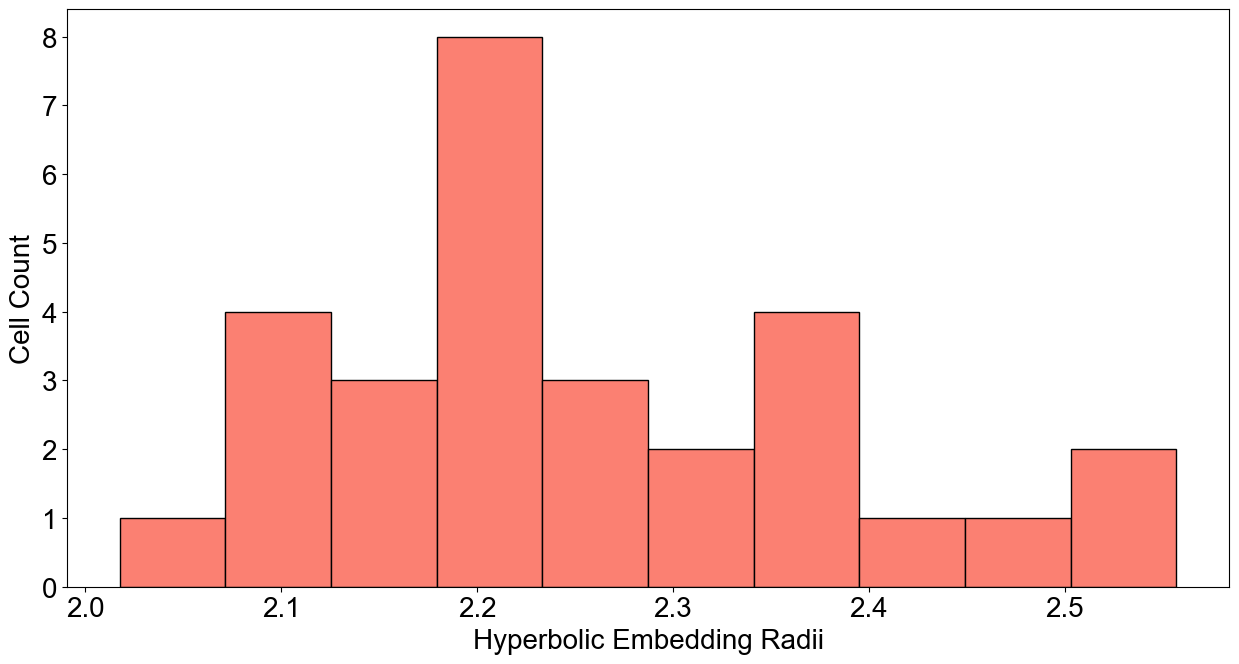

In [71]:
#Histogram of radii
fig, ax = plt.subplots(figsize=(15,7.5))

ax.hist(radii, color ='#fb8072', edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Cell Count', fontsize= 20)
ax.set_xlabel('Hyperbolic Embedding Radii', fontsize=20)

In [ ]:
#DIP analysis of radii
dip, pval = diptest.diptest(radii)

In [ ]:
dip, pval

In [ ]:
all_fits[0]['sig']

In [49]:
#return negative log likelihood of fit
def MDS_lkl(fit, dmat):
    lkl = 0;
    N = fit['sig'].shape[0]
    
    sigs = fit['sig']
    lam = fit['lambda']
    emb_mat = get_embed_dmat(fit)
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            seff = sigs[i]**2 + sigs[j]**2
            lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
    return lkl

#input: optimization fit and distance matrix
def BIC(fit, dmat):
    N,D = fit['euc'].shape
    n = 0.5*N*(N-1)
    k = N*D + N + 1.0 - 0.5*D*(D-1)
    
    return k*np.log(n) + 2.0*MDS_lkl(fit, dmat)

## Bayesian information criteria

There is a lot of formal Bayesian Theory behind this (see chapter 2 here https://urldefense.proofpoint.com/v2/url?u=https-3A__www.inference.org.uk_mackay_thesis.pdf&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=B8GeUuyHfxQP8MseZuhipQ&m=KVww4gh9-XOtp1LqNUc0K-PGXOX3bm2QsokPFlBG9Vs&s=UBtNEdIXatq_zFpG53nmPCLbCnlgIgWigHYhEnBRYyo&e= ), but essentially we are trying to find the minimal number of parameters to describe a dataset. If the data is 5D, we don't want to use 7 parameters to describe it. The BIC is like a cost function that rewards a model that has a better fit to the likelihood function, but penalizes models that increase the number of their parameters. The model which minimizes this function will thus have the ideal trade-off of being able to model the data well without introducing too many parameters and overfitting the data.

In [50]:
all_BIC = [BIC(fit, distance_matrix_squaredp) for fit in all_fits]

In [51]:
all_BIC

[-37.34417950613033,
 -242.19957206363767,
 -278.02576424392373,
 -254.3434134294181,
 -229.66110782234614,
 -171.5939585331887,
 -110.59856085445267,
 -40.379893908754866,
 46.57989382008236,
 127.20555032704078,
 215.01010917853046,
 290.70266728980664,
 363.0846568251859]

As you can see the BIC is minimized at the true dimension of 5. Any more parameters would have been redundant, any less would not have properly fit the data

Text(0, 0.5, 'BIC')

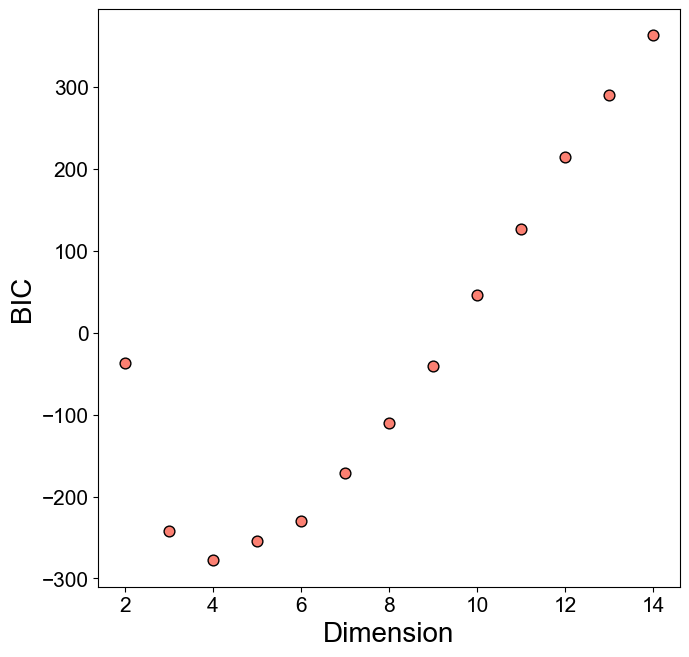

In [58]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

ax.scatter(np.arange(2,15), all_BIC, c = '#fb8072', edgecolor = 'black', s = 60) #cornflowerblue, lightcoral
ax.set_xlabel('Dimension', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('BIC', fontsize=20)

# Re-Running the optimizer
Lets start by generating some 2D data

What is the purpose of re-running?

In [ ]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=2; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_2D = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_2D[j][i] = mat_2D[i][j]
mat_2D = 2.0*mat_2D/np.max(mat_2D)

In [ ]:
#dictionary to specify input to simulation
dat={'N':76, 'D':6, 'deltaij':distance_matrix_squaredp}
#run optimizer
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}

In [ ]:
process_sim(hyp_emb2D)

#### Most pts are well fit, but a few are poorly fit (the ones with high sigma) which adds a lot of scatter to the shepard diagram
#### The optimizer got caught in a false minimum

In [ ]:
#can't find 'emb_mat' parameter 
hyp_emb2D.keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(distance_matrix_squaredp[np.triu_indices(76, k=1)], hyp_emb2D['sig'][np.triu_indices(76, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)

### Strategy: randomize the positions of the poorly fit points, and then return the coordinates as the initial conditions to continue optimizing. This bumps the simulation out of the false minimium without destroying all of the work its already done

In [ ]:
#figure out which pts have high uncertainty, and randomize their coordinates without touching the rest of the points
N_refit = np.where(hyp_emb2D['sig'] > 0.3)[0].shape[0]
hyp_emb2D['euc'][np.where(hyp_emb2D['sig'] > 0.3)] = stats.norm.rvs(size=(N_refit,2))

In [ ]:
#re-reun the optimizer, but this time sepcify the initial condition by passing the previous simulation dictionary
dat={'N':100, 'D':2, 'deltaij':mat_2D}
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2,inits = hyp_emb2D)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}
# tst_2D = ltz_m.optimizing(data=dat, iter=250000, tol_rel_grad=1e2, init=tst_2D)

In [ ]:
process_sim(hyp_emb2D)

### We see that the fit is significantly better, although there are still a few poorly fit points. We could keep iterating the above process until all points are well fit.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(mat_2D[np.triu_indices(100, k=1)], hyp_emb2D['emb_mat'][np.triu_indices(100, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)